In [1]:
import numpy as np
import random 
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import erfc
from  math import log10
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
#%% Parameters

k = 2
n = 2
M = 2**k
R = k/n

#nb = 2  #nb bits/symboles (pour comparer avec différentes modulations)

In [3]:
#%% NN
class Normalization(nn.Module):
        def __init__(self):
            super().__init__()

        def forward(self,x):
            x = np.sqrt(x.size()[1])*x/(torch.norm(x,dim=1,p=2,keepdim=True))
            return x

class Net(nn.Module):
    def __init__(self, Es_N0_dB):
        super(Net, self).__init__()

        self.encoder = torch.nn.Sequential(
            nn.Linear(M,M),
            nn.ReLU(),
            nn.Linear(M,n),
            Normalization()
        )
        self.decoder = torch.nn.Sequential(
            nn.Linear(n,M),
            nn.ReLU(),
            nn.Linear(M,M)
        )        

        self.set_sigma(Es_N0_dB)

    def set_sigma(self, Es_N0_dB):
        self.sigma = (1/np.sqrt(2*10**(Es_N0_dB/10)))

    def forward(self,x):
        x = self.encoder(x)
        x = self.channel(x)
        x = self.decoder(x)
        return x

    def channel(self,x):
        sampled_noise = self.sigma*torch.randn(x.size())
        x += sampled_noise
        return x
        
def generate_data(M,batch_size):
    s = np.random.randint(M,size=(batch_size),dtype=np.int64)
    data = torch.zeros([batch_size,M])
    for i in range(batch_size):
        data[i][s[i]]=1
    return data,torch.from_numpy(s)

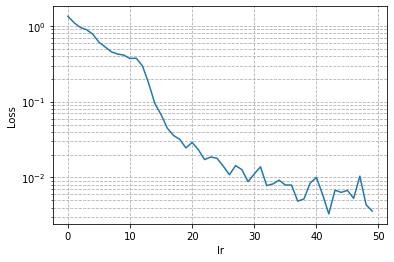

In [4]:
#%% Choosing lr
Eb_N0_dB_train = 7
Es_N0_dB_train = Eb_N0_dB_train + 10*log10(R)
net = Net(Es_N0_dB_train)

n_epochs= 50
batch_size = 1000

Loss = torch.zeros(n_epochs)
criterion = nn.CrossEntropyLoss()
L = [] 
optimizer = optim.Adam(net.parameters(), lr=0.001)
for i in range(n_epochs):
    for j in range(100):
        input_data, label = generate_data(M,batch_size)
        output = net(input_data)
        # Backpropagate gradient
        #criterion = nn.MSELoss()
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    Loss[i]=loss
    Const = net.encoder(torch.eye(M))
    L.append(Const)
        # Update weights and biases
        #optimizer = optim.SGD(net.parameters(), lr=Lr[i])
        
#Loss_tr = gaussian_filter1d(Loss.detach().numpy(), sigma=5)
Loss_tr = Loss.detach().numpy()
plt.figure()
plt.plot(Loss_tr)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("lr")
plt.grid(True,which="both", linestyle='--')
plt.show()

In [5]:
torch.save(L,'const_2_2.pt')
print(len(L))
print(L[0])

50
tensor([[1.3978, 0.2146],
        [0.9992, 1.0008],
        [1.3647, 0.3708],
        [0.3724, 1.3643]], grad_fn=<DivBackward0>)


In [8]:
#%% Testing
Eb_N0_dB = np.linspace(0,10,num=11)
Pe = np.linspace(0,0,num=len(Eb_N0_dB))
P = 1000
for i in range(len(Eb_N0_dB)):
    Es_N0_dB = Eb_N0_dB[i] + 10*log10(R)
    net.set_sigma(Es_N0_dB)
    nb_mes = 0
    nb_mes_false = 0
    while(nb_mes_false < 100):
        data,s = generate_data(M,P)

        output = net.encoder(data)
        output = net.channel(output)
        output = net.decoder(output)
        nb_mes += P

        nb_mes_false += torch.sum(s != torch.argmax(output,dim=1))
            
    Pe[i] = nb_mes_false/nb_mes
    print(Eb_N0_dB[i], Pe[i])

0.0 0.6050000190734863
1.0 0.49300000071525574
2.0 0.4650000035762787
3.0 0.4359999895095825
4.0 0.4020000100135803
5.0 0.3240000009536743
6.0 0.28200000524520874
7.0 0.2290000021457672
8.0 0.1770000010728836
9.0 0.10199999809265137
10.0 0.08900000154972076


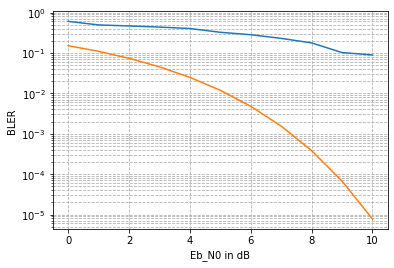

In [9]:
#%% Figures
plt.figure()
plt.plot(Eb_N0_dB,Pe)
Pb = 0.5*erfc(10**(Eb_N0_dB/20))
P  = 1-(1-Pb)**n
plt.plot(Eb_N0_dB,P)
plt.yscale('log')
plt.ylabel("BLER")
plt.xlabel("Eb_N0 in dB")
plt.grid(True,which="both", linestyle='--')
plt.show()

In [10]:
print(net.encoder(torch.eye(M)))


tensor([[ 0.5748,  1.2921],
        [ 1.0199,  0.9797],
        [-1.4135,  0.0450],
        [ 0.0564, -1.4131],
        [-1.3091, -0.5350],
        [ 1.3092,  0.5347],
        [ 0.0566,  1.4131],
        [ 0.5967, -1.2822],
        [-0.9879, -1.0119],
        [-0.4881,  1.3273],
        [ 1.0295, -0.9696],
        [-0.9598,  1.0386],
        [ 1.4140,  0.0248],
        [ 1.3172, -0.5149],
        [-0.5114, -1.3185],
        [-1.2903,  0.5789]], grad_fn=<DivBackward0>)


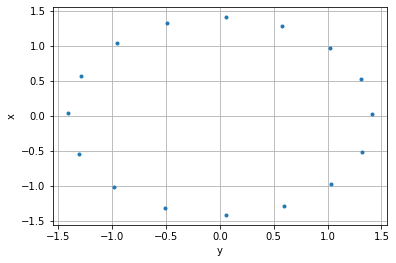

In [11]:
constellation= np.array(())
for m in range(M):
    input_data = torch.zeros([1,M]) #Hot vector
    input_data[0][m]= 1
    c = net.encoder(input_data)

    constellation = np.concatenate((constellation, c.detach().numpy()[0,:]),axis=0)
plt.figure()
plt.ylabel("x")
plt.xlabel("y")
plt.plot(constellation[0::2],constellation[1::2],'.')
plt.grid()
plt.show()


(array([ 8.,  9., 27., 46., 50., 61., 67., 98., 76., 94., 92., 93., 84.,
        60., 59., 48., 26., 15.,  9.,  2.]),
 array([-2.45045233, -2.19632183, -1.94219134, -1.68806084, -1.43393035,
        -1.17979985, -0.92566936, -0.67153887, -0.41740837, -0.16327788,
         0.09085262,  0.34498311,  0.59911361,  0.8532441 ,  1.1073746 ,
         1.36150509,  1.61563559,  1.86976608,  2.12389657,  2.37802707,
         2.63215756]),
 <BarContainer object of 20 artists>)

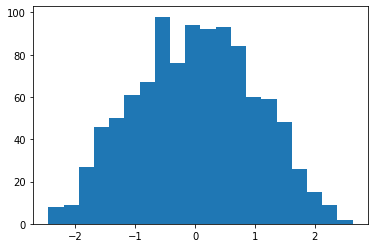

In [81]:
plt.hist(constellation[0::2],20)